# bayesian credible learning

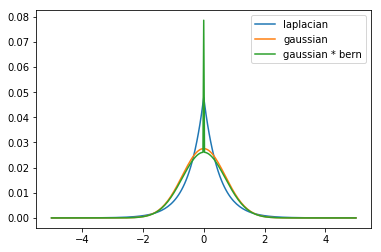

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

normalize = lambda x: x / x.sum()
lap = lambda x: np.exp(-np.abs(x) * 2)
gas = lambda x: np.exp(-x**2)
p = 0.95
gas_x_bern = lambda x: p * gas(x) + (1-p) * (x==0) * sum(gas(x)) / p

x = np.array(sorted(list(np.linspace(-5,5,200)) + [0]))
plt.plot(x, normalize(lap(x)), label='laplacian')
plt.plot(x, normalize(gas(x)), label='gaussian')
plt.plot(x, normalize(gas_x_bern(x)), label='gaussian * bern')

plt.legend()
plt.show()

Another explanation of why l1 + l2 does not work: notice the dependence on m


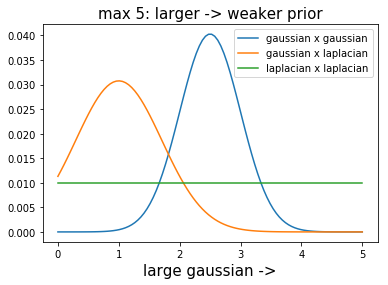

In [4]:
print('Another explanation of why l1 + l2 does not work: notice the dependence on m')
m = 5
x = np.linspace(0, m, 100)
plt.plot(x, normalize(gas(x) * gas(m-x)), label='gaussian x gaussian')
plt.plot(x, normalize(gas(x) * lap(m-x)), label='gaussian x laplacian')
plt.plot(x, normalize(lap(x) * lap(m-x)), label='laplacian x laplacian')
#plt.plot(x, normalize(gas(x) * gas_x_bern(m-x)), label='gaussian x gauss*bern')

plt.xlabel('large gaussian ->', fontsize=15)
plt.title('max {}: larger -> weaker prior'.format(m), fontsize=15)
plt.legend()
plt.show()

**Variational Inference**

$\log p(x) = ELBO(q, \theta) + KL(q(\theta) || p(\theta | x))$

$ELBO(q, \theta) = \mathbb{E}_{q(\theta)} \log p(x|\theta)  - \mathbb{E}_{q(\theta)} (\log q(\theta) - \log p(\theta))$

It should be clear that if we ignore the later term, we are essentially assuming uniform distribution on $\theta$.

We use a multivariate gaussian as variational distribution $q$. We use parametric variational inference, with parameters $L \in \mathbb{R}^{d \times c}$ and $\mu \in \mathbb{R}^d$ with $c \leq d$. We have
$$\theta \sim \mathbb{N}(\mu, LL^T)$$

With a gaussian prior and guassian likelihood, the covariance matrix is $(\Sigma_{prior} + X^T X)^{-1}$. This says that 2 highly correlated features will become highly negatively correlated. Also note that with no prior, the optimal solution is MLE (may not drive variance to 0 though).

KL in general may not be trackable, use other measures to approximate, eg., make mu part exact and if this is still not feasible, try mcmc or I can try to restrict q to have useful property by initialize its parameters.

Note that when I do prediction, I just need to take the mean of theta if the loss function is MSE

In [5]:
import torch
from torch.utils import data
import tqdm
import seaborn as sns
import pandas as pd
from scipy.linalg import block_diag
import math

def genCovX(C, n): # helper function to create N(0, C)
    # C is the covariance matrice (assume to be psd)
    # n is number of examples
    C = np.array(C)
    A = np.linalg.cholesky(C)
    d, _ = C.shape
    Z = np.random.randn(n, d)
    X = Z.dot(A.T) 
    return X.astype(np.float32)

class Q(torch.nn.Module):
    
    def __init__(self, d, c):
        super(Q, self).__init__()
        self.d = d
        self.c = c
        # todo: right now this approximation only does for the first c columns
        # need to support choosing which columns
        self.L = torch.nn.Parameter(torch.randn(d, c))
        self.mu = torch.nn.Parameter(torch.randn(d, 1))
        
    def forward(self, bs=10): # sample
        eps = torch.randn(bs, self.c, 1)
        theta = torch.matmul(self.L, eps) + self.mu
        return theta.squeeze(2) # (bs, d)
    
class Q2(torch.nn.Module):
    '''the standard mean field approximation'''
    def __init__(self, d, c='dummy'):
        super(Q2, self).__init__()
        self.d = d
        self.c = d # ignore c b/c we use mean field: assume independence
        self.sqrt_diag = torch.nn.Parameter(torch.randn(d))
        self.L = torch.diag(self.sqrt_diag)
        self.mu = torch.nn.Parameter(torch.randn(d, 1))
        
    def forward(self, bs=10): # sample
        eps = torch.randn(bs, self.c, 1)
        theta = torch.matmul(self.L, eps) + self.mu
        return theta.squeeze(2) # (bs, d)
        
def bdot(a, b): # batch wise dot product
    return (a * b).sum(-1).unsqueeze(-1)

def forward(theta, x):
    return bdot(theta, x)

def KL_l1(param_prior, param_post, weights):
    # a proxy for KL
    l = 0
    for pri, post, w in zip(param_prior, param_post, weights):
        l += w * (abs(pri - post)).sum()
    return l

def KL_l2(param_prior, param_post, weights):
    # a proxy for KL
    l = 0
    for pri, post, w in zip(param_prior, param_post, weights):
        l += w * ((pri - post)**2).sum()
    return l

def cov_(L):
    return L.mm(L.t())

def corr(L):
    cov = cov_(L)
    d = cov.diag().view(-1, 1)
    denom = torch.sqrt(d.mm(d.t()))
    return cov / denom

def train(q, loader, bs, KL_coef, prior_width, KL, criterion, opt, n_epochs, variance_penalty='C'):
    '''
    L is L based (d, c)
    C is LL^T based
    V is (L*L).sum(1)
    '''
    assert variance_penalty in ['L', 'C', 'V'], 'variance penalty has to be L|C|V'
    N = len(loader.dataset)
    for i in tqdm.tqdm(range(n_epochs)):
        for x, y in loader:
            theta = q(bs) # sampling
            o = forward(theta, x)

            q.zero_grad() # just replace the latter KL part with EYE
            # the alignment by L is the reason why appproximation only works for first few coordinate
            if variance_penalty == 'L':
                l = criterion(o, y) + 1/N * KL([np.sqrt(prior_width) * torch.eye(q.d)[:,:q.c], torch.zeros(d, 1)], 
                                               [q.L, q.mu], [KL_coef, 1/prior_width])
            elif variance_penalty == 'C':
                l = criterion(o, y) + 1/N * KL([prior_width * torch.eye(q.d), torch.zeros(d, 1)], 
                                               [cov_(q.L), q.mu], [KL_coef, 1/prior_width])
            elif variance_penalty == 'V':
                l = criterion(o, y) + 1/N * KL([prior_width * torch.ones(q.d), torch.zeros(d, 1)], 
                                               [(q.L * q.L).sum(1), q.mu], [KL_coef, 1/prior_width])
            
            l.backward()
            opt.step()

def getCov(group_corr, n_per_groups, d):
    assert sum(n_per_groups) == d, 'must sum to d'
    blocks = []
    for n_per_group in n_per_groups:
        base = np.diag(np.ones(n_per_group))
        base[base == 0] = group_corr
        blocks.append(base)
    covariance = block_diag(*blocks)
    return covariance

In [6]:
d = 9
group_corr = 0.99
n_per_groups = [1, 1, 1, 1, 5]
covariance = getCov(group_corr, n_per_groups, d)   
n = 300
bs = 10
real_theta = (3 * torch.ones(d)).view(1, d)

# set ground truth
f = torch.nn.Linear(d, 1)
f.weight.data = real_theta
f.bias.data.fill_(0)

# define dataset
X = genCovX(covariance, n)
X = torch.from_numpy(X)
y = f(X).detach()
dataset = data.TensorDataset(X, y)
loader = data.DataLoader(dataset, batch_size=bs)

In [10]:
c = 9 # cov_approximation number
n_epochs = 1000 # 2000
# q = Q(d, c) # Q2(d, c)
opt = torch.optim.Adam(q.parameters())    
KL = KL_l2
KL_coef = 0.1
prior_width = 100
# doesn't seem to make a different when KL_coef is adjusted
# V seems bad as it can have correlated features
variance_penalty = 'C' # 'L|C|V'
criterion = torch.nn.MSELoss()

####### train
q_prior_cov = cov_(q.L).clone().detach().numpy()
q_prior_corr = corr(q.L).clone().detach().numpy()
q_prior_mean = q.mu.clone().clone().detach().numpy().ravel()

train(q, loader, bs, KL_coef, prior_width, KL, criterion, opt, n_epochs, variance_penalty=variance_penalty)
    
q_post_cov = cov_(q.L).clone().detach().numpy()
q_post_corr = corr(q.L).clone().detach().numpy()
q_post_mean = q.mu.clone().detach().numpy().ravel()

100%|██████████| 1000/1000 [00:20<00:00, 47.92it/s]


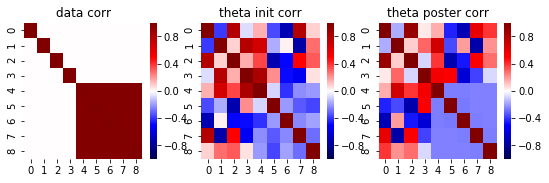

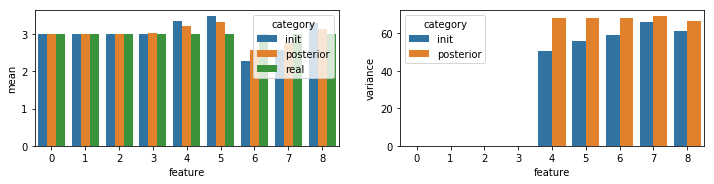

In [11]:
######## plotting code
fig = plt.figure(figsize=(9, 2.5))
ax = fig.add_subplot(1, 3, 1)
diag_cov = np.diag(np.array(covariance)).reshape(-1, 1)
sns.heatmap(covariance / np.sqrt(diag_cov.dot(diag_cov.T)), vmin=-1, vmax=1, cmap='seismic')
ax.title.set_text('data corr')

ax = fig.add_subplot(1, 3, 2)
sns.heatmap(q_prior_corr, vmin=-1, vmax=1, cmap='seismic')
ax.title.set_text('theta init corr')

ax = fig.add_subplot(1, 3, 3)
sns.heatmap(q_post_corr, vmin=-1, vmax=1, cmap='seismic')
ax.title.set_text('theta poster corr')
plt.show()

fig = plt.figure(figsize=(12, 2.5))
fig.add_subplot(1, 2, 1)
df = pd.DataFrame({'feature': list(range(d)) + list(range(d)) + list(range(d)), 
                   'mean': list(q_prior_mean) + list(q_post_mean) + list(real_theta.numpy().ravel()), 
                   'category': (['init'] * d) + (['posterior'] * d) + (['real'] * d)})
sns.barplot(x='feature', y='mean', hue='category', data=df)

fig.add_subplot(1, 2, 2)
df = pd.DataFrame({'feature': list(range(d)) + list(range(d)), 
                   'variance': list(np.diag(q_prior_cov)) + list(np.diag(q_post_cov)), 
                   'category': (['init'] * d) + (['posterior'] * d)})
sns.barplot(x='feature', y='variance', hue='category', data=df)
plt.show()